# Imports

In [1]:
import pandas as pd
import numpy as np

# Loading the data

In [2]:
dataframe = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')
dataframe.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


# Data Exploration
## Corrolation matrix

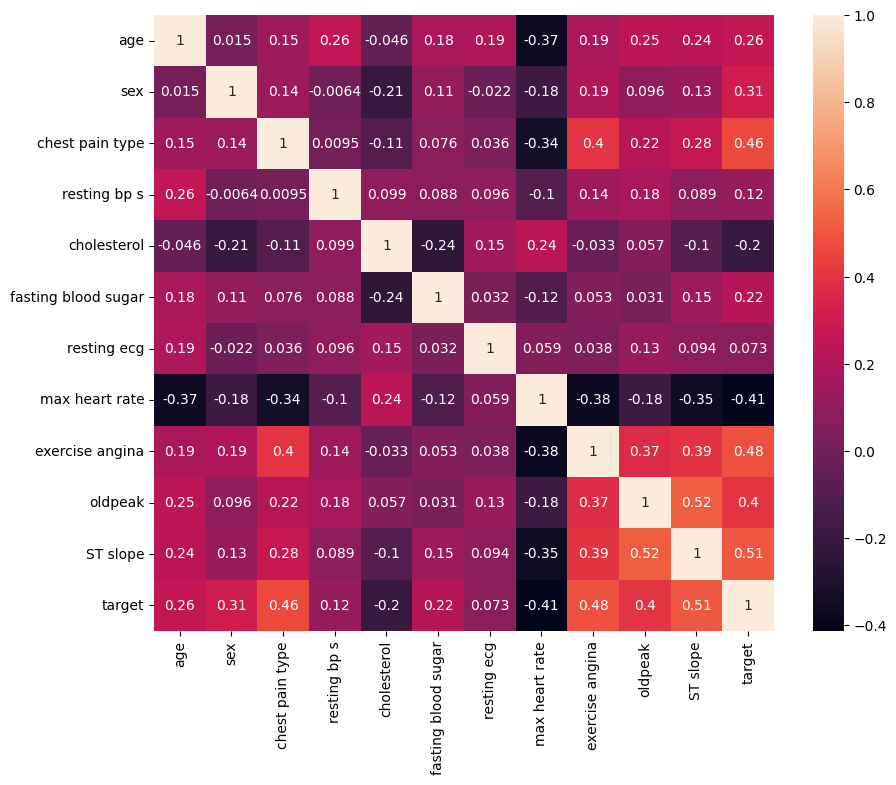

In [3]:
import seaborn as sn
import matplotlib.pyplot as plt

corr_matrix = dataframe.corr()
plt.figure(figsize=(10, 8))  # Set the figure size to 10 inches by 8 inches
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [4]:
# Define the dataset X and y
X = pd.DataFrame(dataframe).drop(['target'],axis=1)  # Your input features
y = pd.Series(dataframe['target'])  # Your target variable


# Analysis
 grid search for the best combination of number of features, best k features selection algorithm and of course the classifier

In [5]:
# Define the dataset X and y
X = pd.DataFrame(dataframe).drop(['target'],axis=1)  # Your input features
y = pd.Series(dataframe['target'])  # Your target variable

### Utils

In [17]:
def saveConfusionMatix(cm,result):

    # Set the figure size
    plt.figure(figsize=(8, 6))

    # Plot the confusion matrix as a heatmap
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Set axis labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    # plt.title(f'Confusion Matrix - {result["classifier"]} ({result["feature_selection_algorithm"]}, k={result["k"]})')
    # plt.title(f'Confusion Matrix - {result["classifier"]} (degree={result["degree"]})')
    plt.title(f'Confusion Matrix - {result["classifier"]} (n_estimators={result["n_estimators"]}, criterion={result["criterion"]})')

    # Save the plot as an image file
    # output_file = f'confusion_matrices/confusion_matrix_{result["classifier"]}_{result["feature_selection_algorithm"]}_k{result["k"]}.png'
    # output_file = f'confusion_matrices/svc/confusion_matrix_{result["classifier"]}_{result["degree"]}.png'
    output_file = f'confusion_matrices/random_forest/confusion_matrix_{result["classifier"]}_{result["n_estimators"]}_{result["criterion"]}.png'
    plt.savefig(output_file)

In [7]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(conf_matrix):
    # Extract values from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate precision
    precision = tp / (tp + fp)

    # Calculate sensitivity
    sensitivity = tp / (tp + fn)

    #Calculate specifity
    specifity = tn / (tn + fp)

    return precision, specifity, sensitivity

### Grid search

c:\Users\gilak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gilak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gilak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\gilak\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

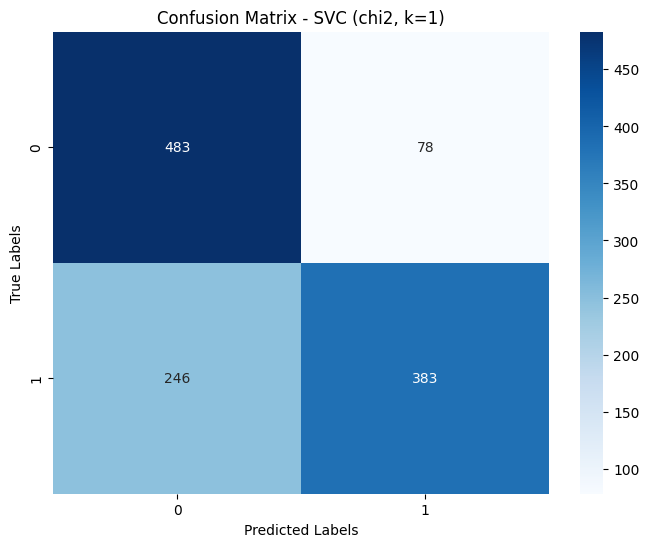

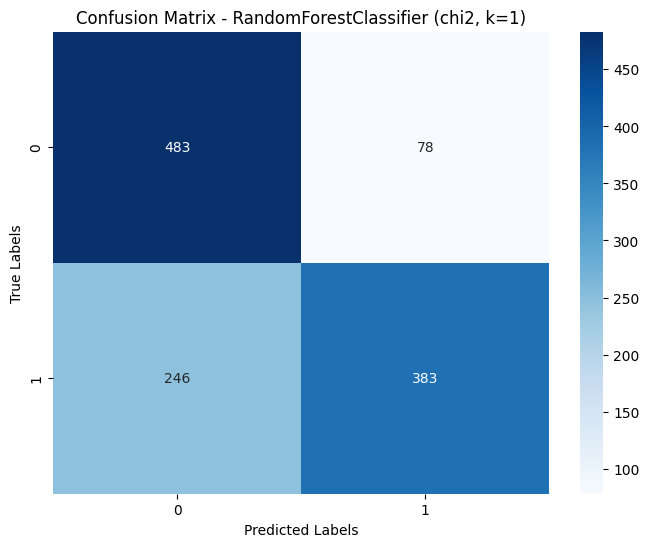

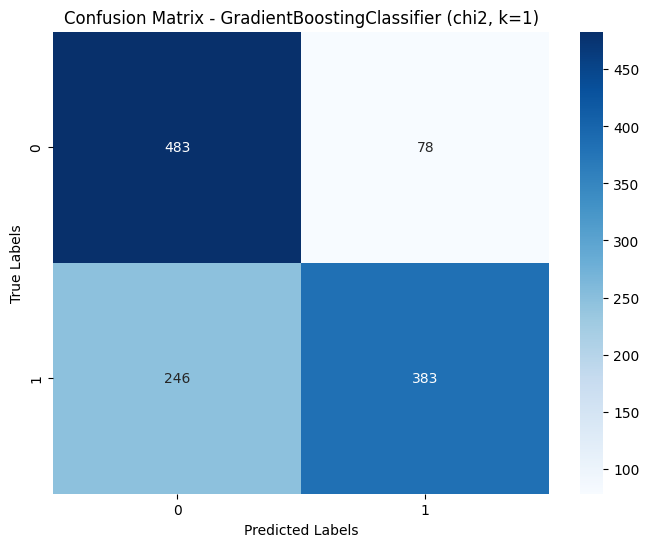

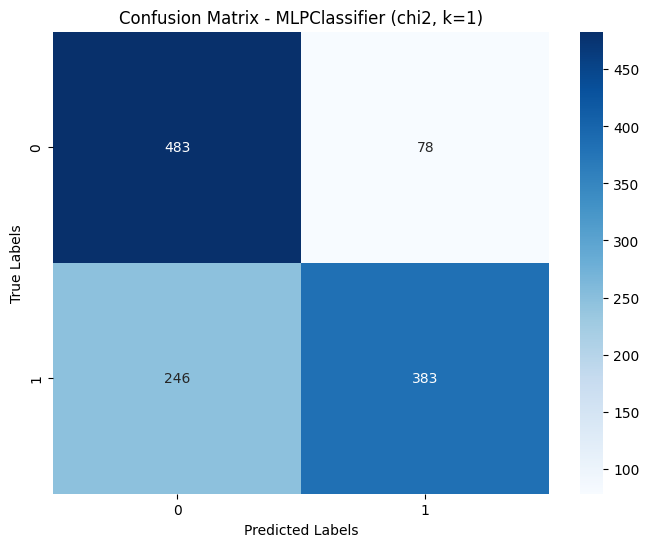

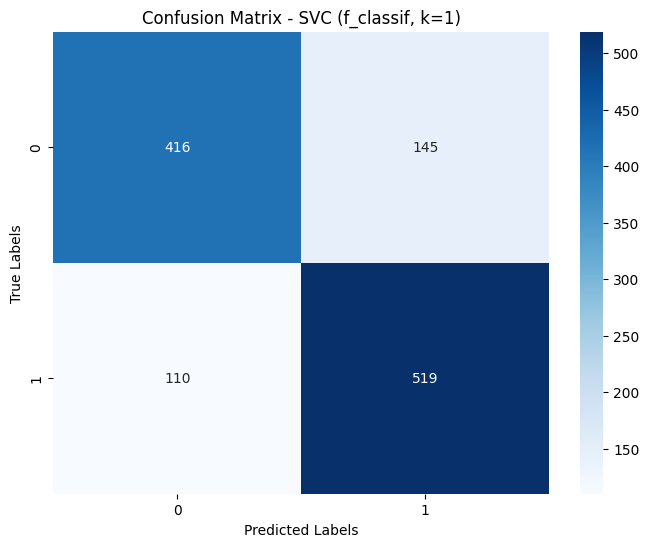

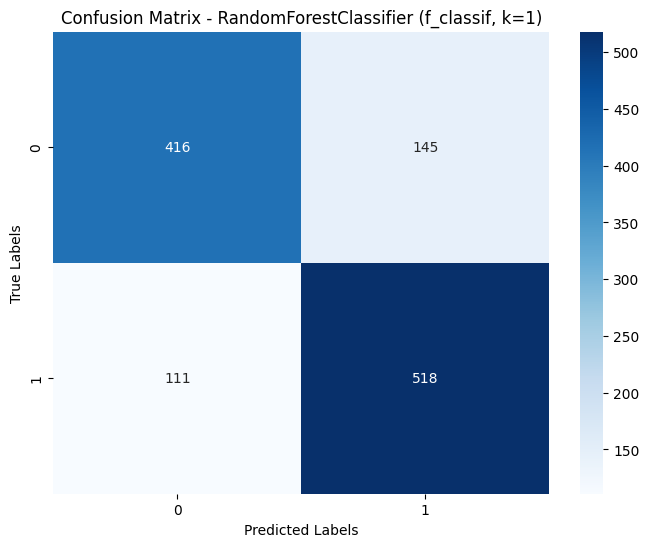

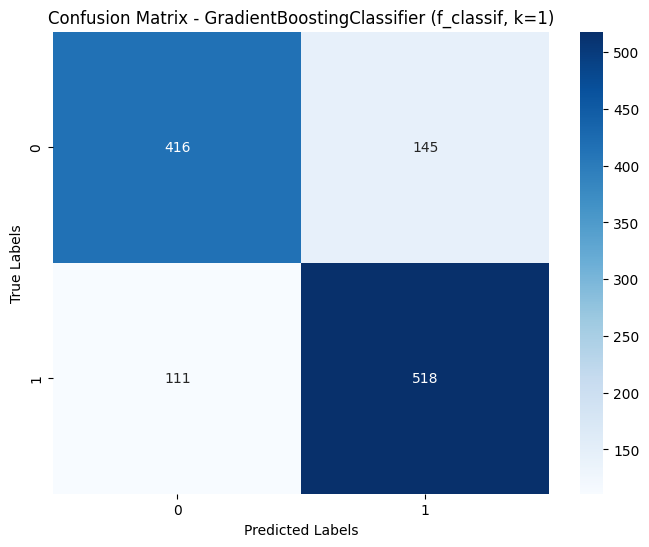

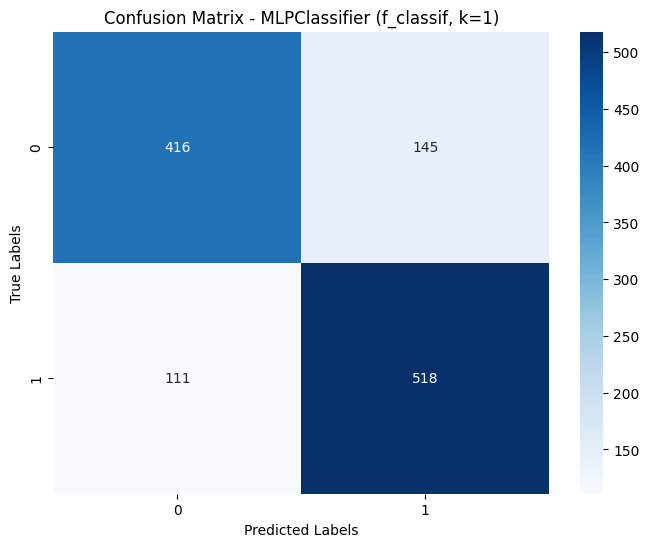

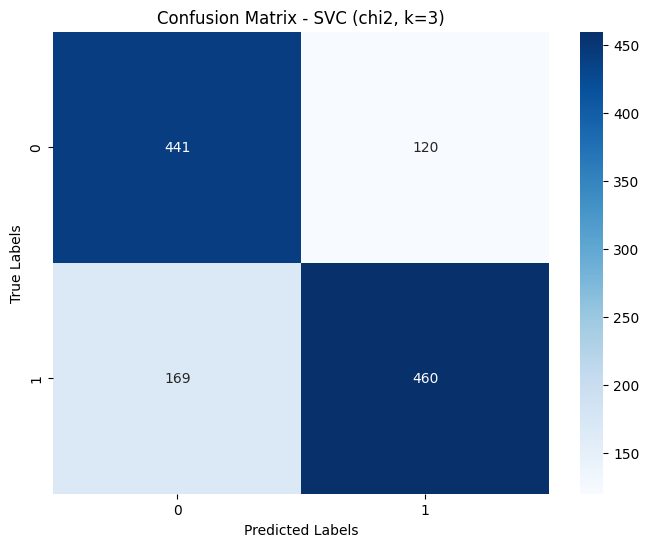

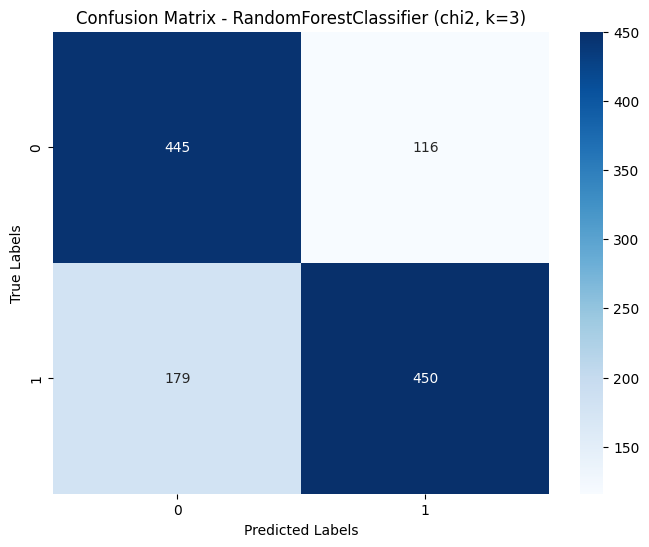

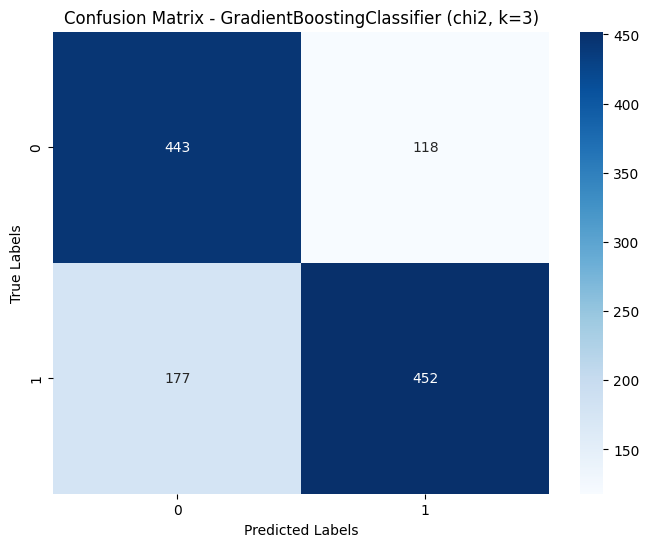

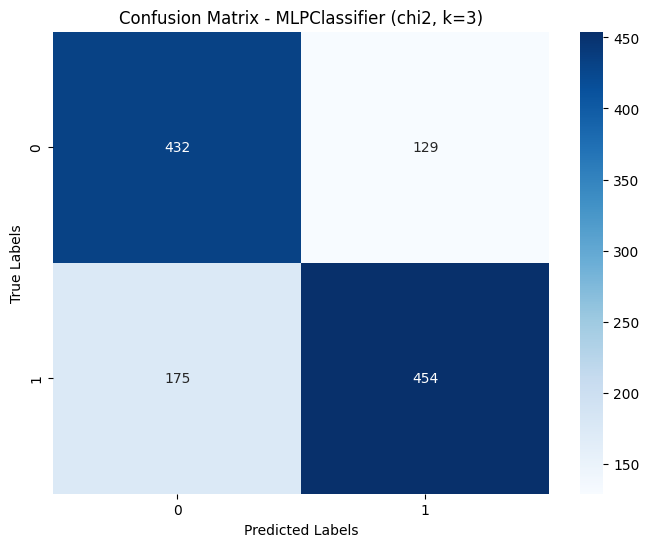

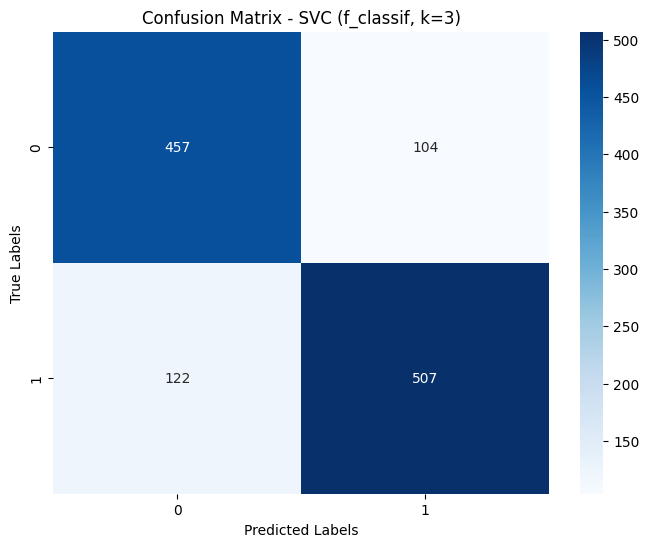

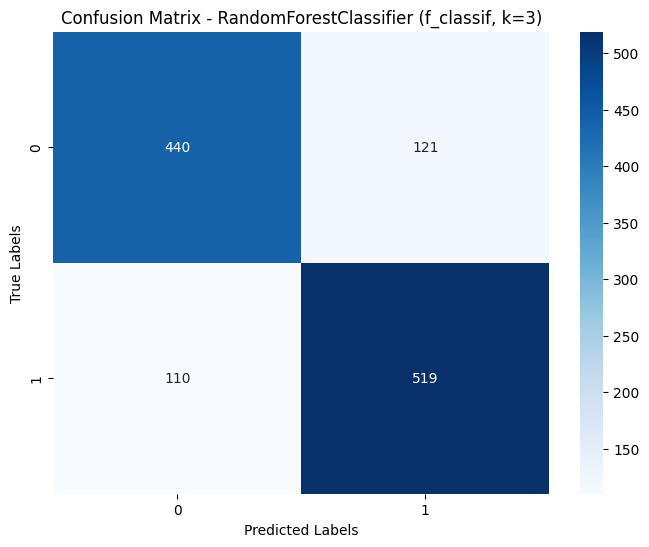

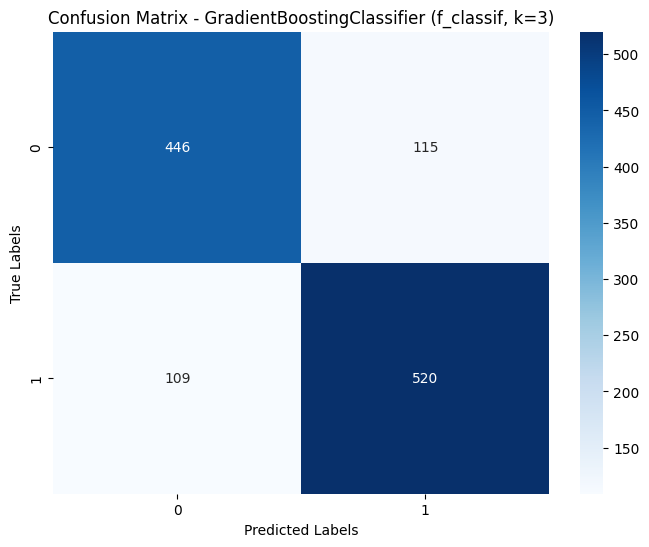

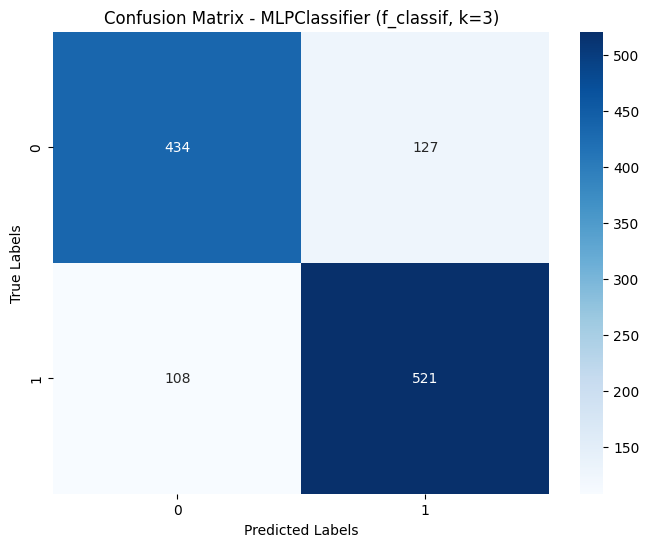

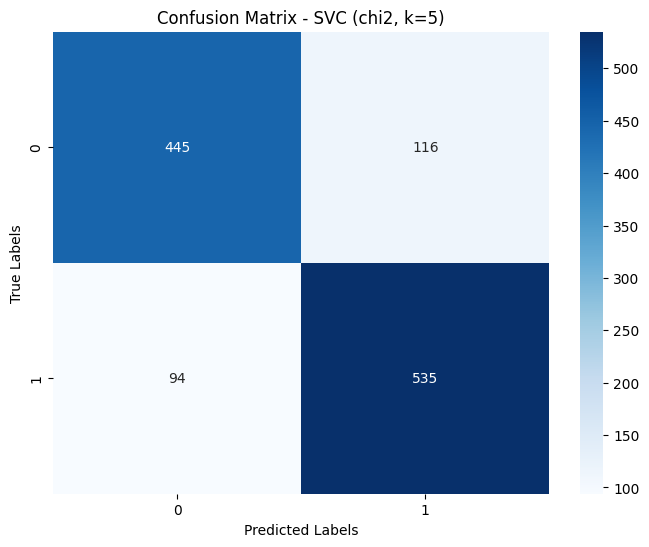

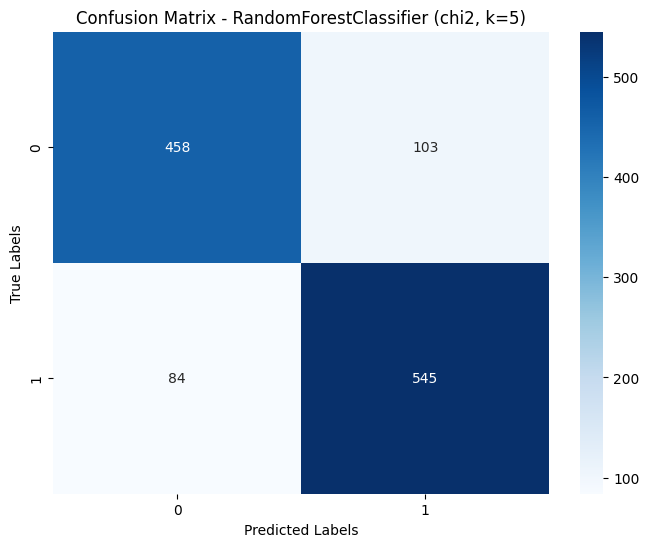

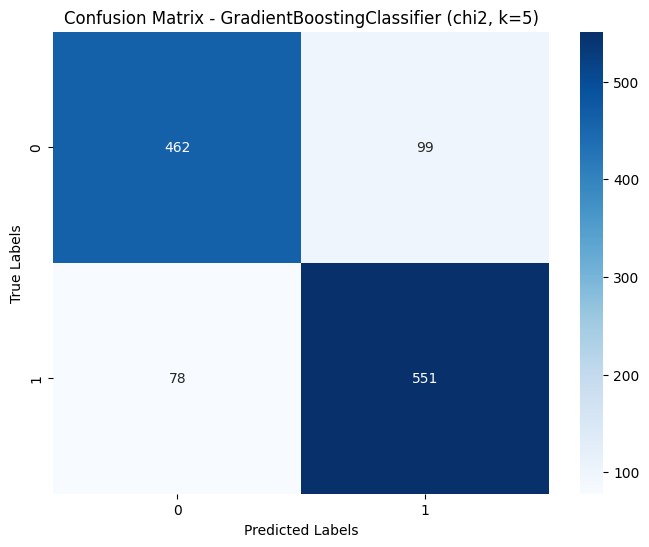

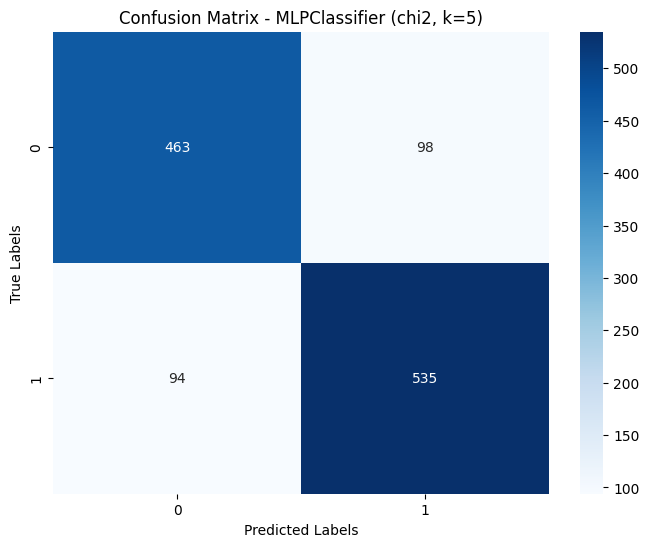

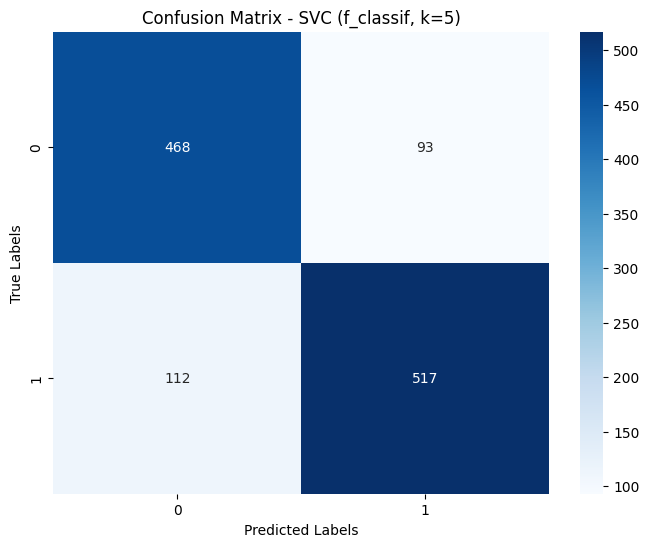

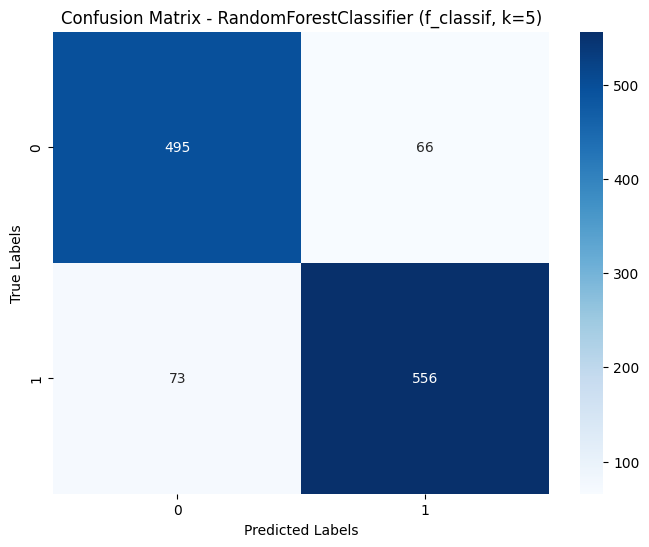

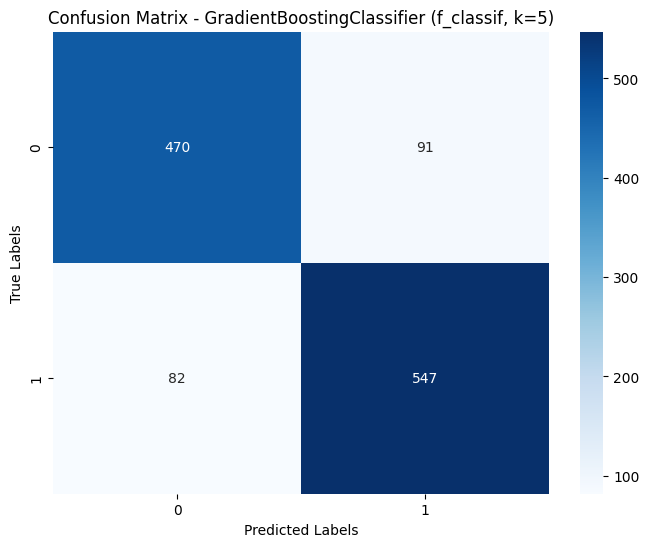

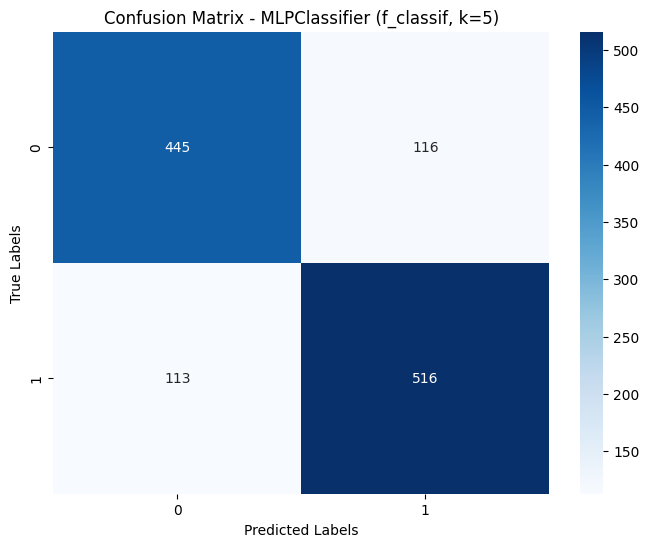

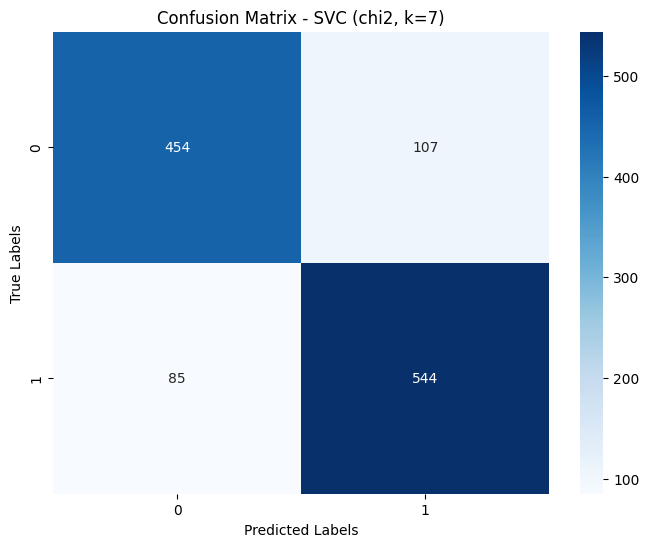

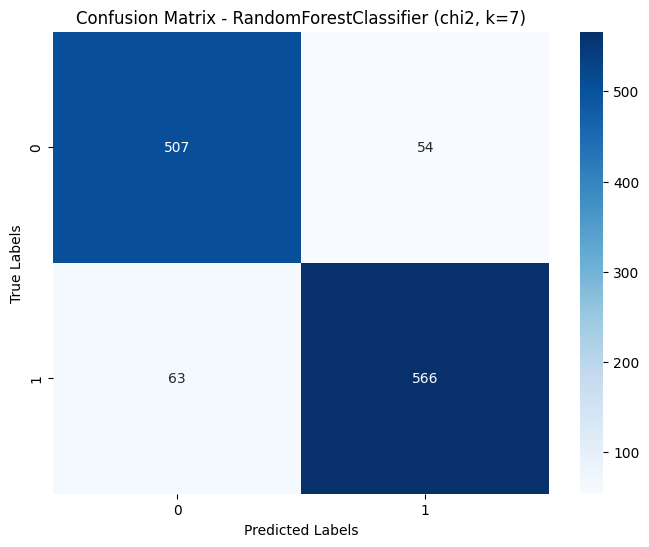

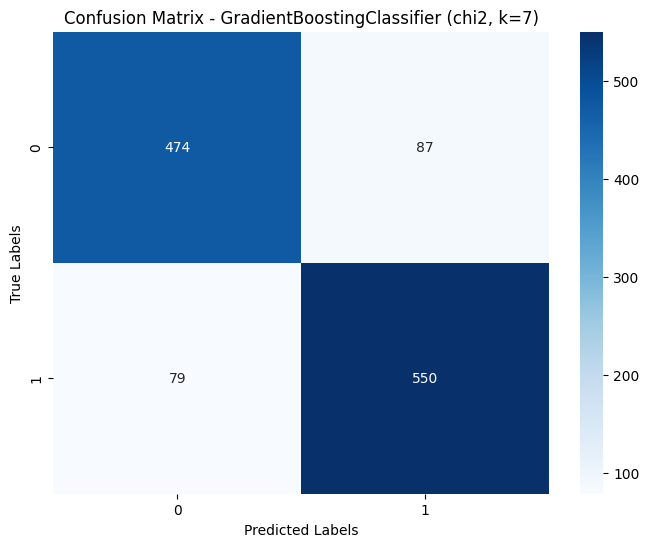

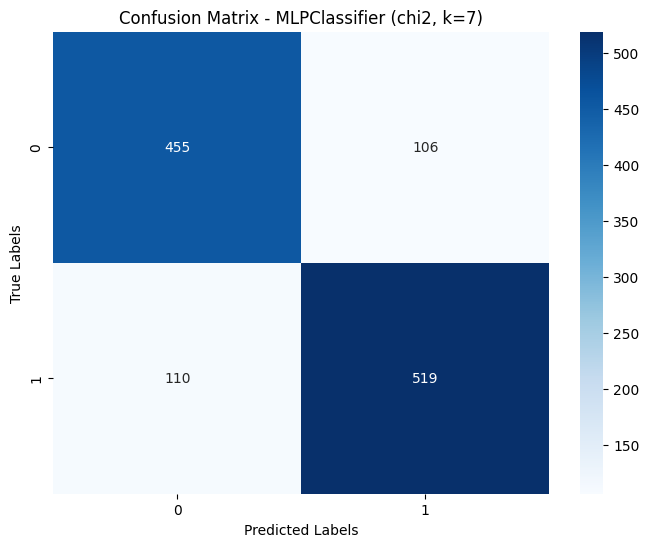

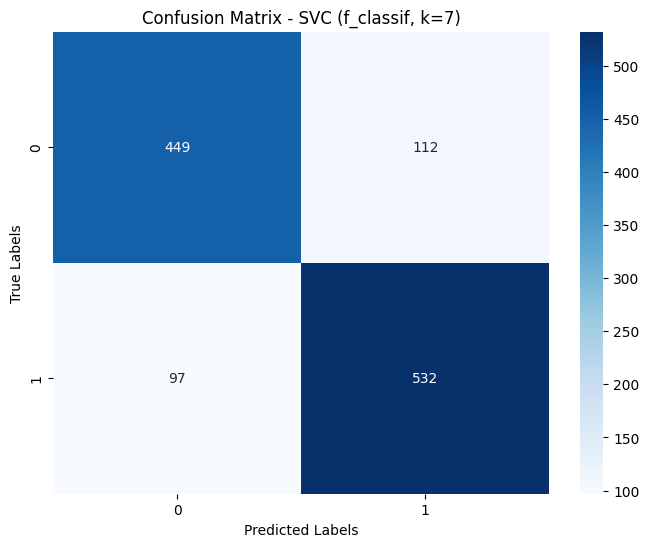

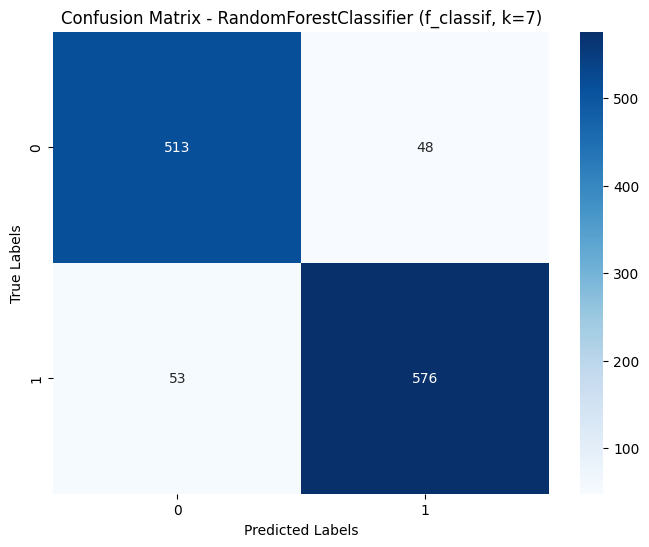

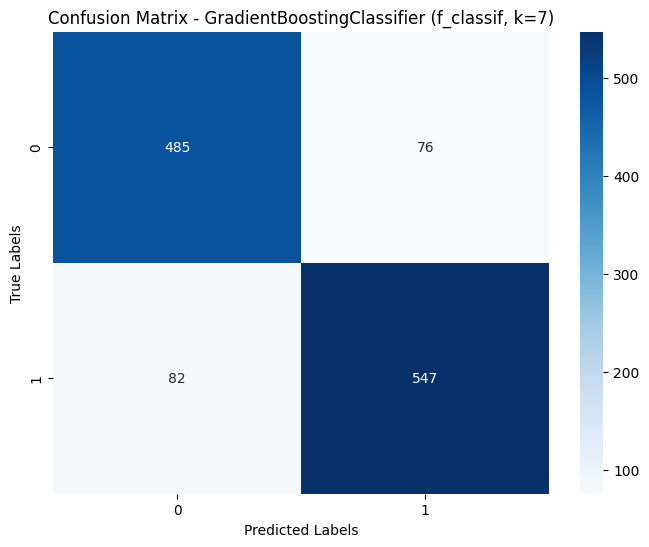

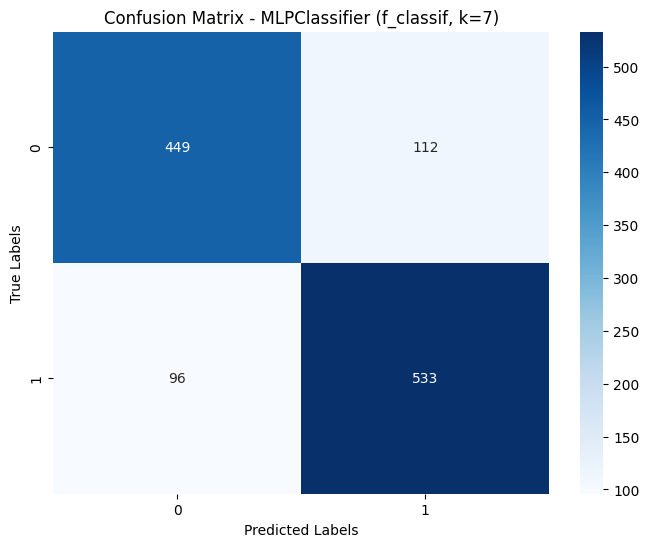

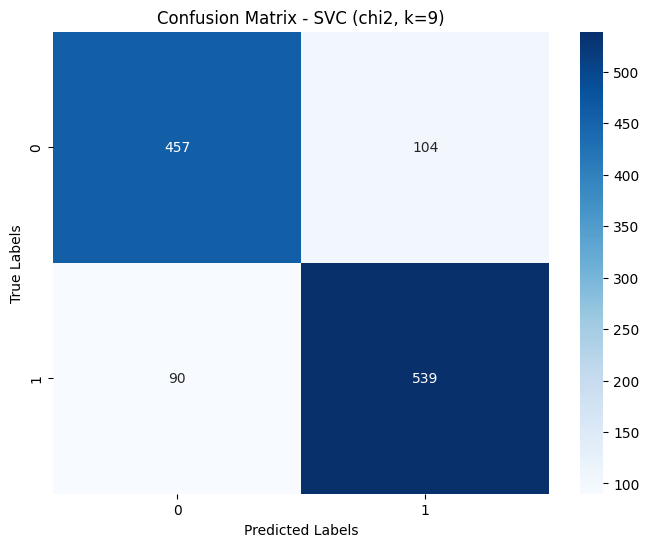

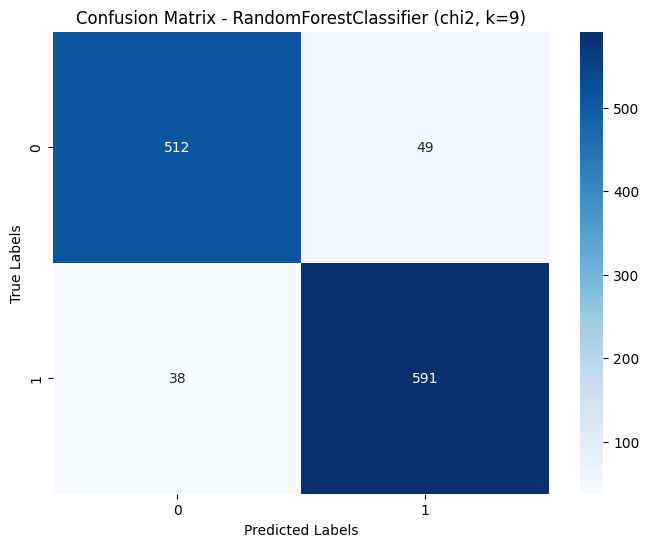

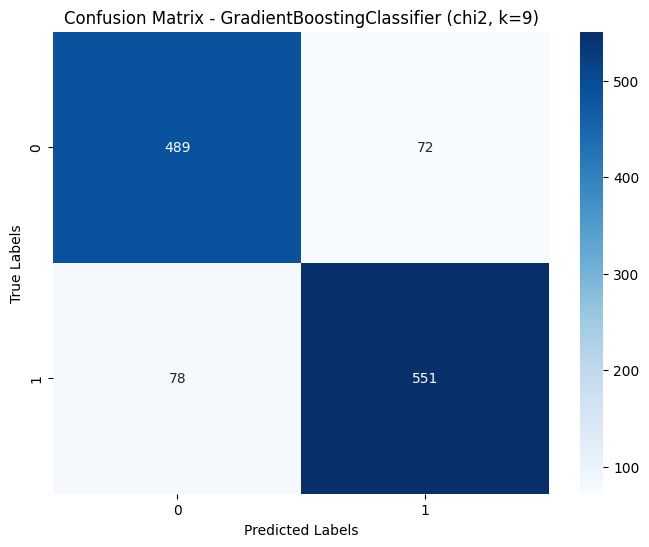

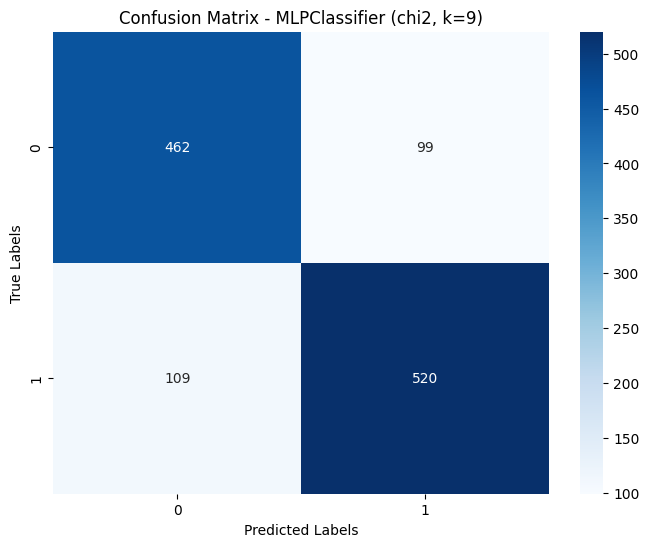

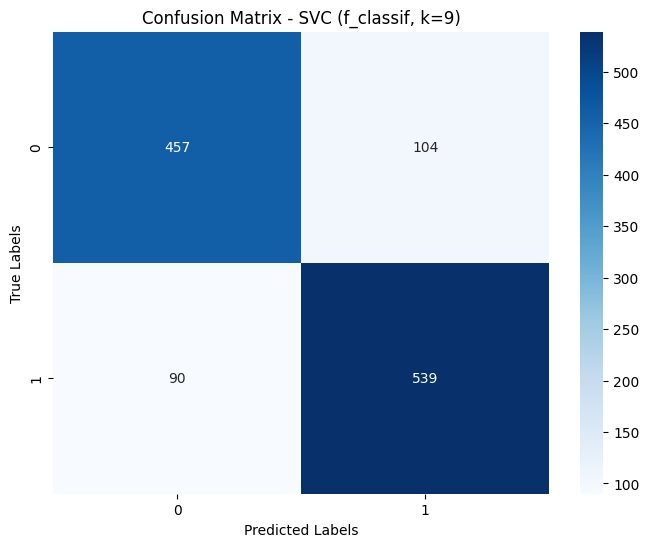

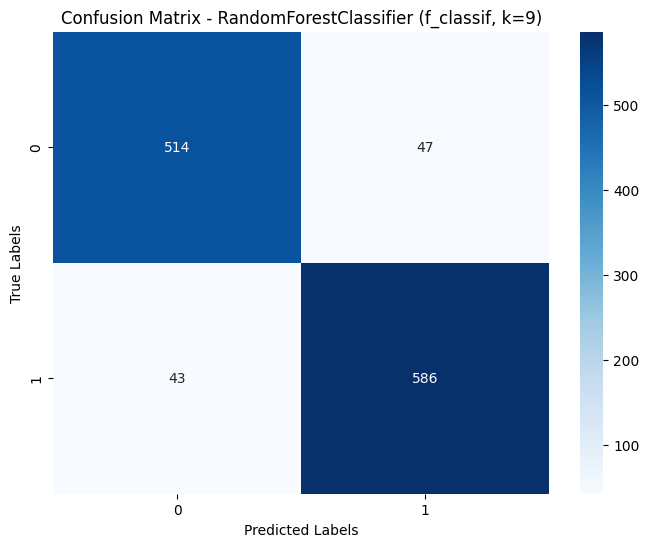

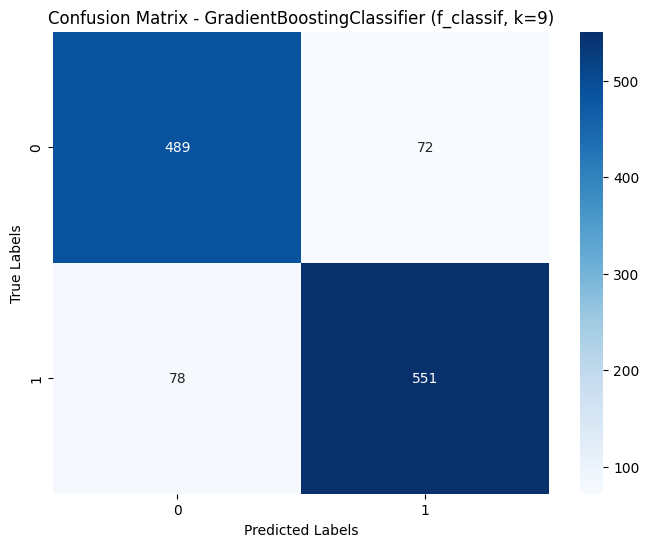

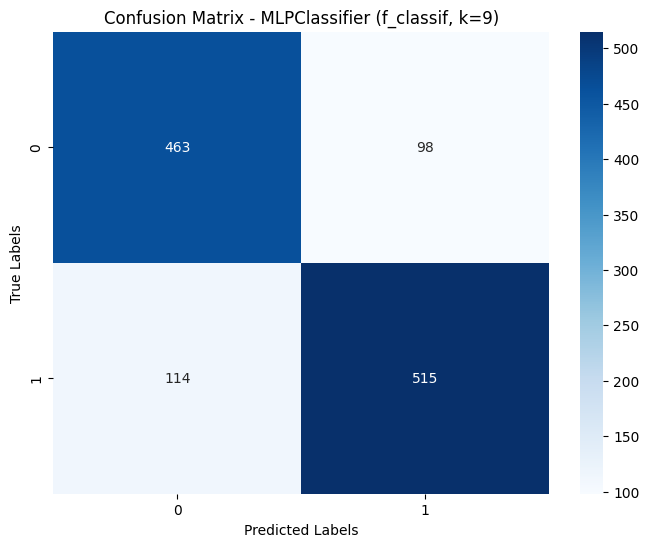

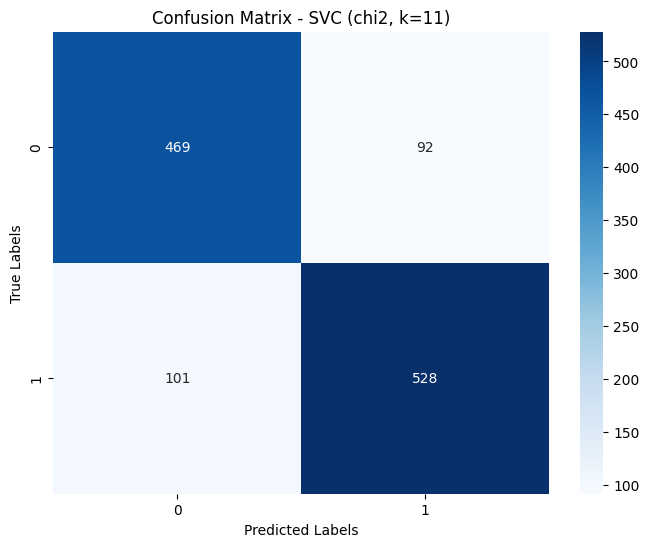

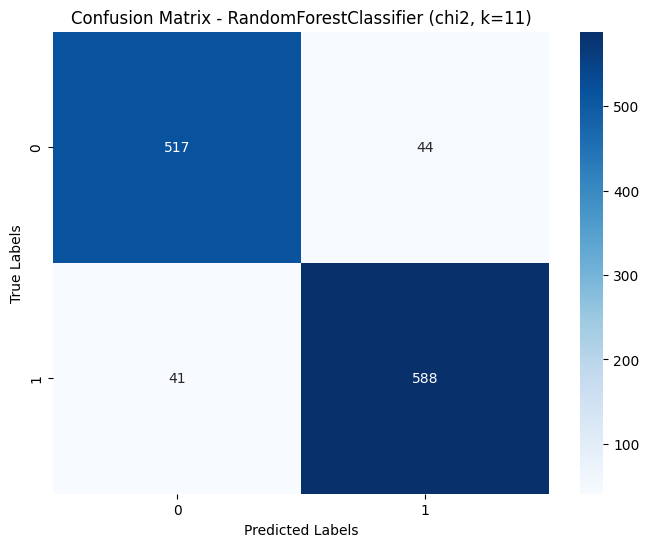

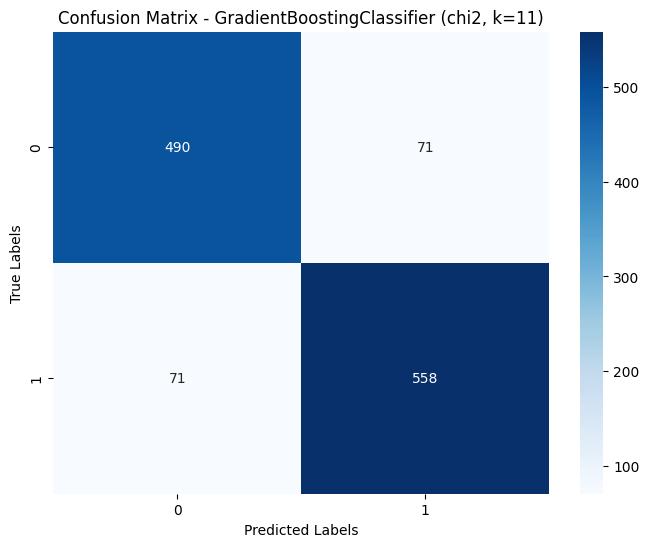

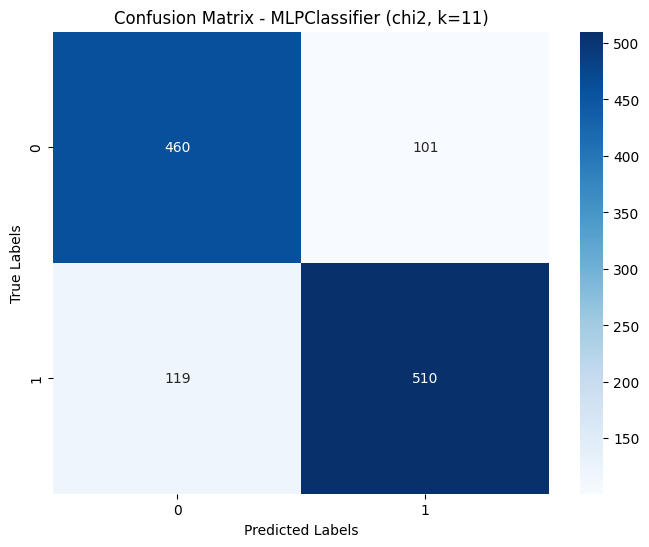

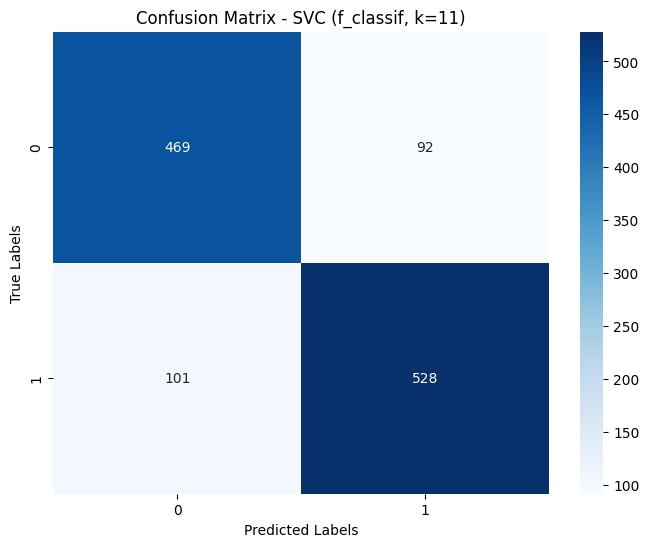

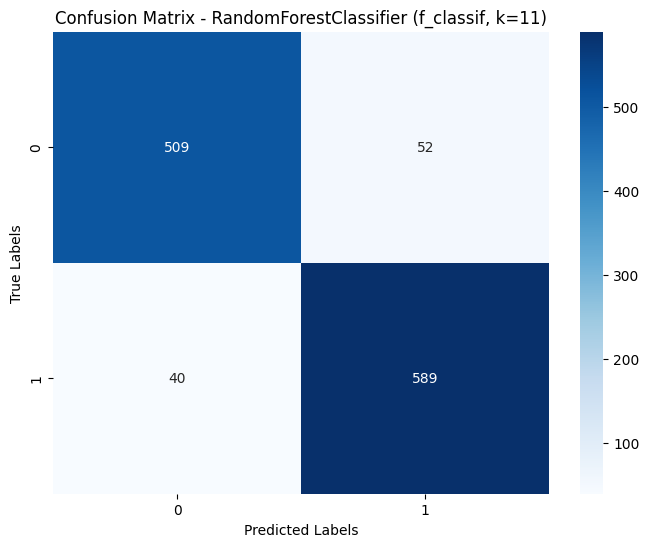

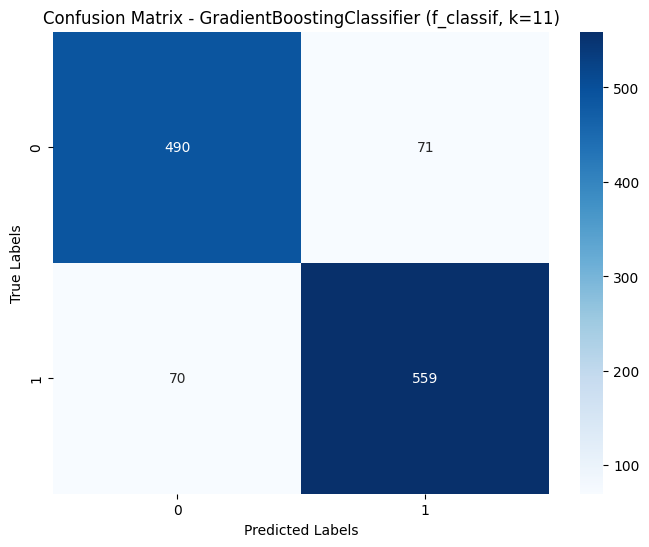

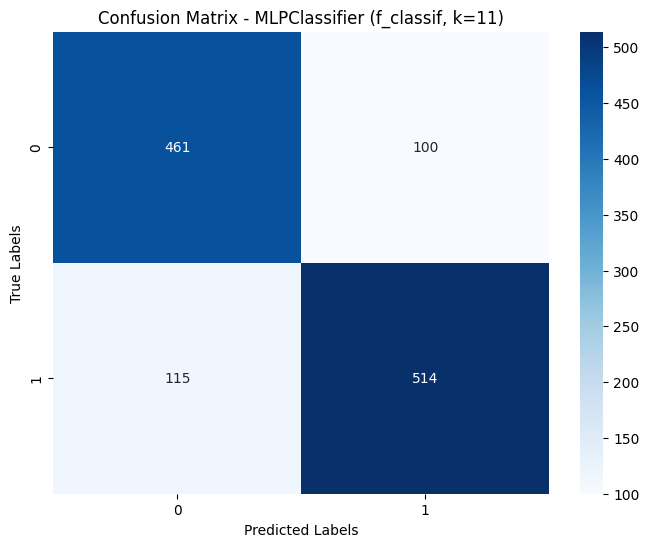

In [10]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

numberOfFeatures = [1, 3, 5, 7, 9, 11]
selectKBestFeatureAlgorithm = [chi2, f_classif]
classifiers = [SVC(), RandomForestClassifier(),GradientBoostingClassifier(),MLPClassifier()]


results = []

for k in numberOfFeatures:
    for featureSelectionAlgorithm in selectKBestFeatureAlgorithm:
        # Perform feature selection using SelectKBest
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        selector = SelectKBest(featureSelectionAlgorithm, k=k) 
        X_new = selector.fit_transform(X_scaled, y)
        selected_features = X.columns[selector.get_support(indices=True)]

        for classifier in classifiers:
            # Perform cross-validation
            scores = cross_val_score(classifier, X_new, y, cv=5)
            y_pred = cross_val_predict(classifier, X_new, y, cv=5)
            # Calculate confusion matrix
            cm = confusion_matrix(y, y_pred)
            precision, specifity, sensitivity = calculate_metrics(cm)

            # Store the results
            result = {
                'k': k,
                'feature_selection_algorithm': featureSelectionAlgorithm.__name__,
                'classifier': classifier.__class__.__name__,
                'mean_accuracy': np.mean(scores),
                'std_accuracy': np.std(scores),
                'precision':precision,
                'specifity':specifity,
                'sensitivity':sensitivity,
                'selected_features':[*selected_features],
            }
            saveConfusionMatix(cm, result)
            results.append(result)


## Saving the results

In [12]:
# Sort the results based on mean_accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['mean_accuracy'], reverse=True)
# save results into CSV for later analysis
pd.DataFrame(sorted_results).to_csv('results.csv')

# Get the best combination (first element in the sorted list)
best_combination = sorted_results[0]

# Print the best combination
print("Best Combination:")
print(best_combination)


Best Combination:
{'k': 11, 'feature_selection_algorithm': 'chi2', 'classifier': 'RandomForestClassifier', 'mean_accuracy': 0.9310924369747899, 'std_accuracy': 0.0321751087715574, 'precision': 0.930379746835443, 'specifity': 0.9215686274509803, 'sensitivity': 0.9348171701112877, 'selected_features': ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']}


## Features predictive power analysis

In [18]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
selector = SelectKBest(f_classif, k=11) 
X_new = selector.fit_transform(X, y)

# Get the scores and feature names
scores = selector.scores_
feature_names = X.columns[selector.get_support(indices=True)]

# Create a DataFrame to store the scores and feature names
score_df = pd.DataFrame({'Feature': feature_names, 'Score': scores})
score_df.sort_values(by="Score", ascending=False)
# Print the scores for each feature
display(score_df.sort_values(by="Score", ascending=False))
score_df.sort_values(by="Score", ascending=False).to_csv('features_score.csv')


,Feature,Score
10,ST slope,408.000692
8,exercise angina,358.492580
2,chest pain type,319.072661
7,max heart rate,244.704259
9,oldpeak,224.118427
1,sex,127.450037
0,age,87.580158
5,fasting blood sugar,58.533163
4,cholesterol,48.661642
3,resting bp s,17.774984


## SVC analysis

Best SVC Combination:
{'classifier': 'SVC', 'mean_accuracy': 0.8529411764705884, 'std_accuracy': 0.023916385665139005, 'degree': 4, 'precision': 0.8733552631578947, 'specifity': 0.8627450980392157, 'sensitivity': 0.8441971383147854}


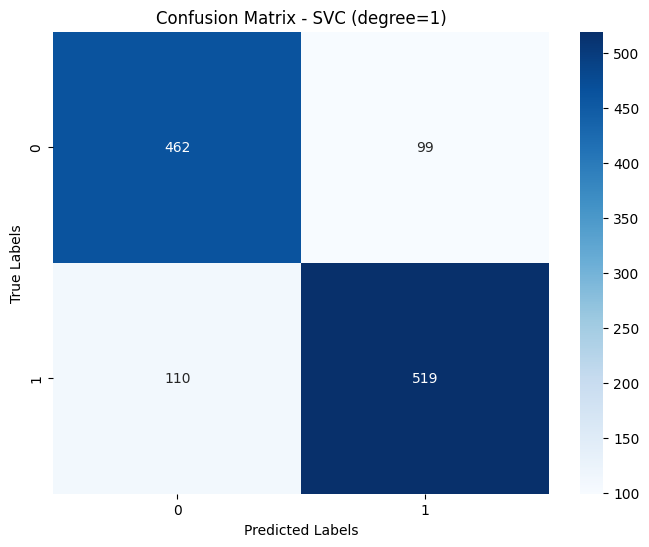

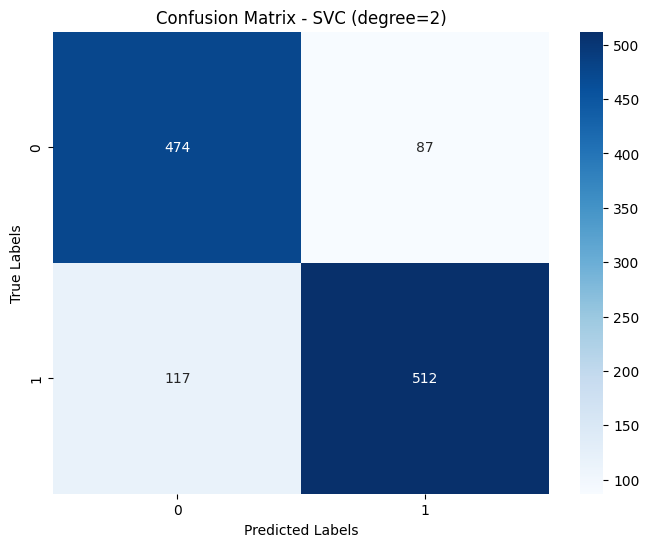

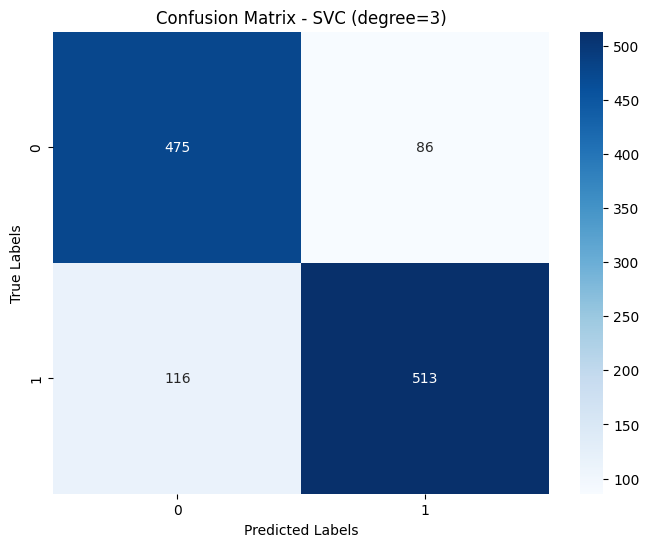

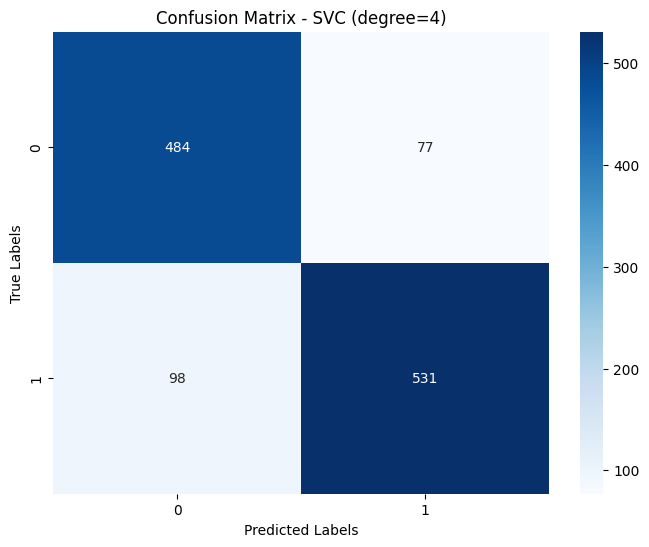

In [15]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
svc_results=[]
for degree in range (1,5):
    svc =  SVC(kernel='poly', degree=degree)
    scores = cross_val_score(svc, X_scaled, y, cv=5)
    y_pred = cross_val_predict(svc, X_scaled, y, cv=5)
    # Calculate confusion matrix
    cm = confusion_matrix(y, y_pred)
    precision, specifity, sensitivity = calculate_metrics(cm)

    # Store the results
    result = {
        'classifier': svc.__class__.__name__,
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'degree':degree,
        'precision':precision,
        'specifity':specifity,
        'sensitivity':sensitivity,
    }
    saveConfusionMatix(cm, result)
    svc_results.append(result)

# Sort the results based on mean_accuracy in descending order
svc_sorted_results = sorted(svc_results, key=lambda x: x['mean_accuracy'], reverse=True)
# save results into CSV for later analysis
pd.DataFrame(svc_sorted_results).to_csv('svc_results.csv')
# Print the best combination
print("Best SVC Combination:")
print( svc_sorted_results[0])

## Random Forest analysis

Best Random Combination:
{'classifier': 'RandomForestClassifier', 'mean_accuracy': 0.9352941176470588, 'std_accuracy': 0.03460716013777143, 'n_estimators': 300, 'criterion': 'gini', 'precision': 0.9265625, 'specifity': 0.9162210338680927, 'sensitivity': 0.9427662957074722}


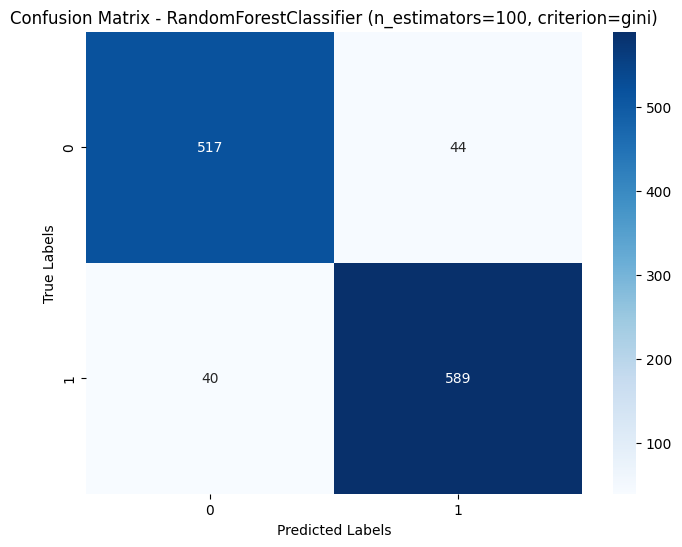

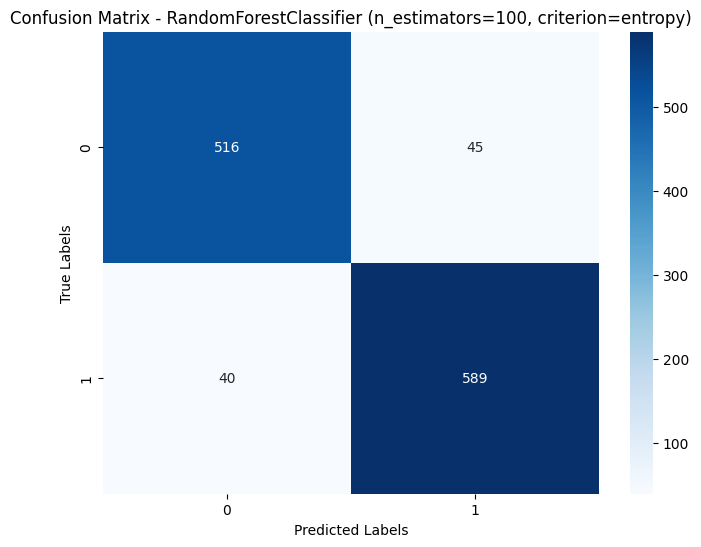

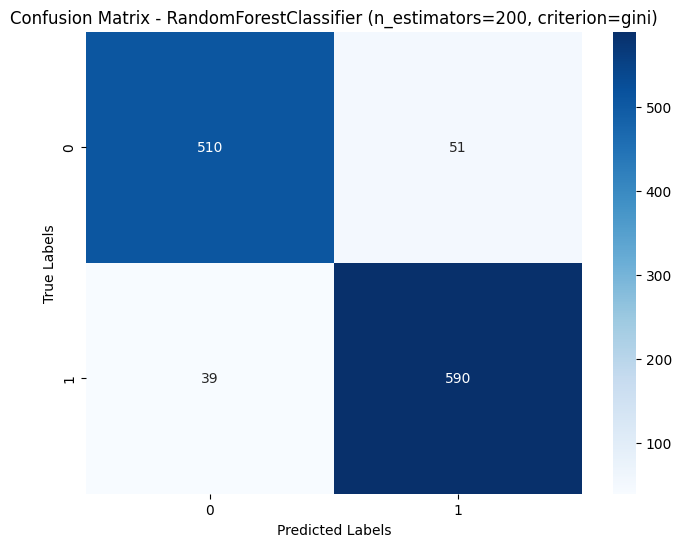

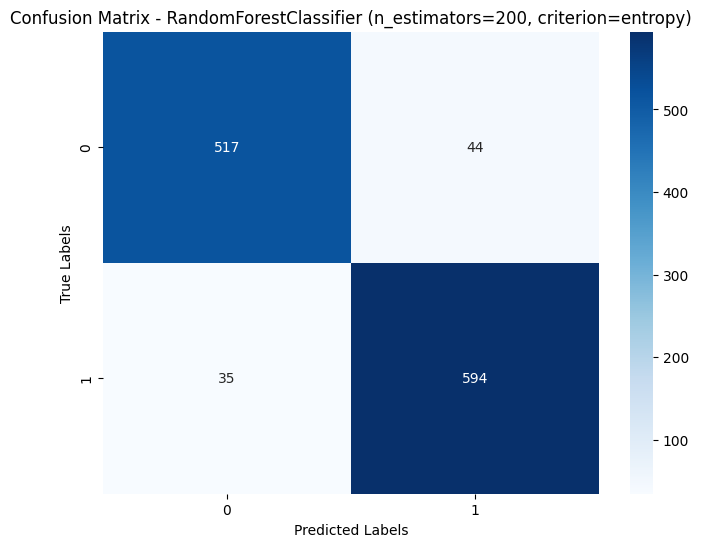

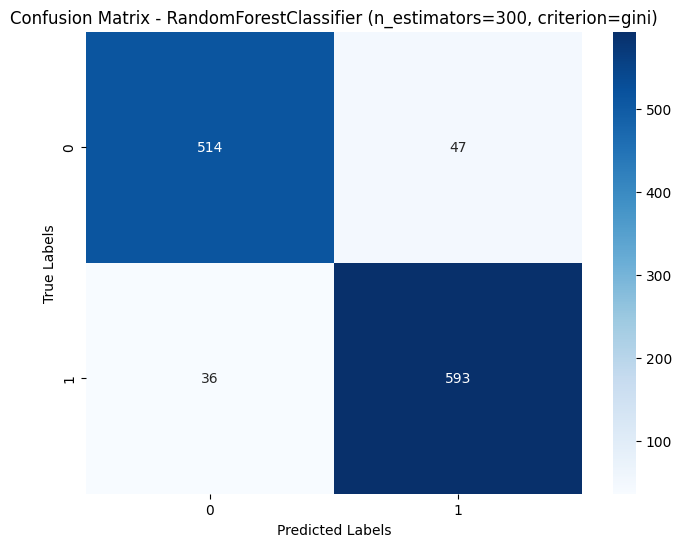

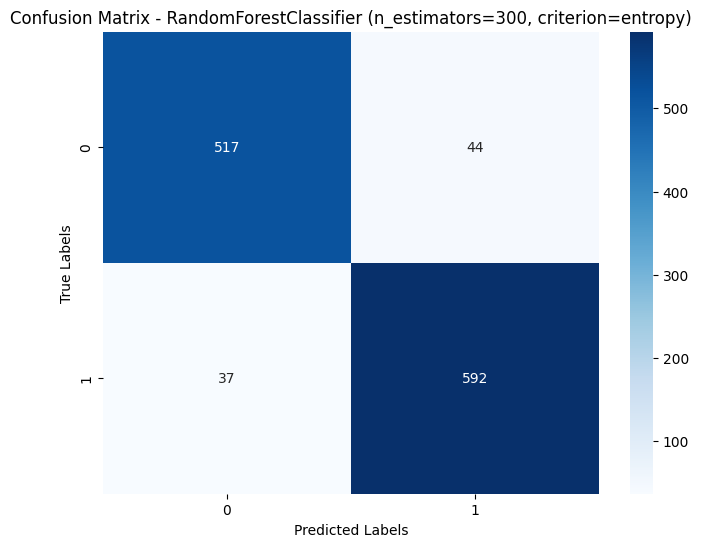

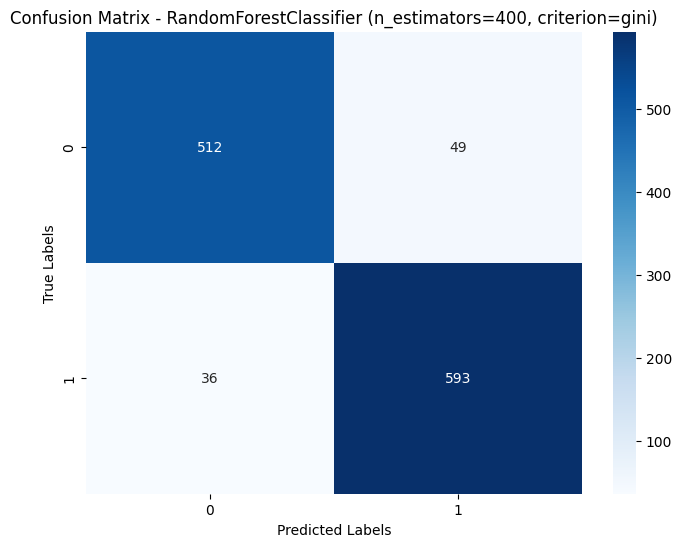

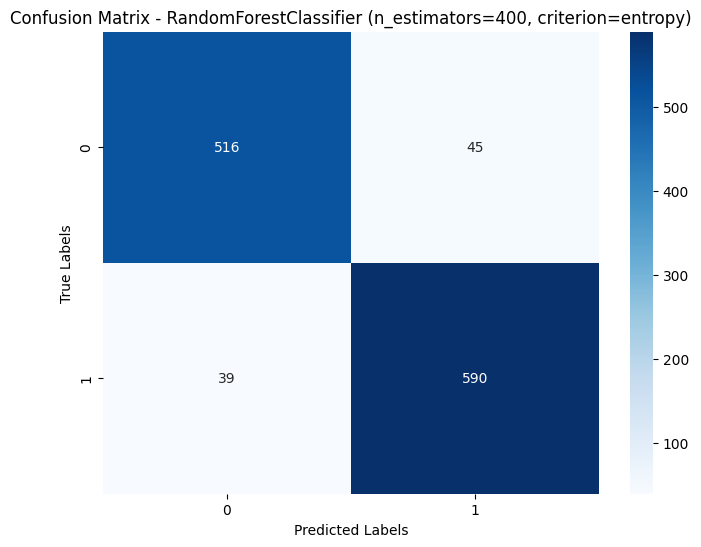

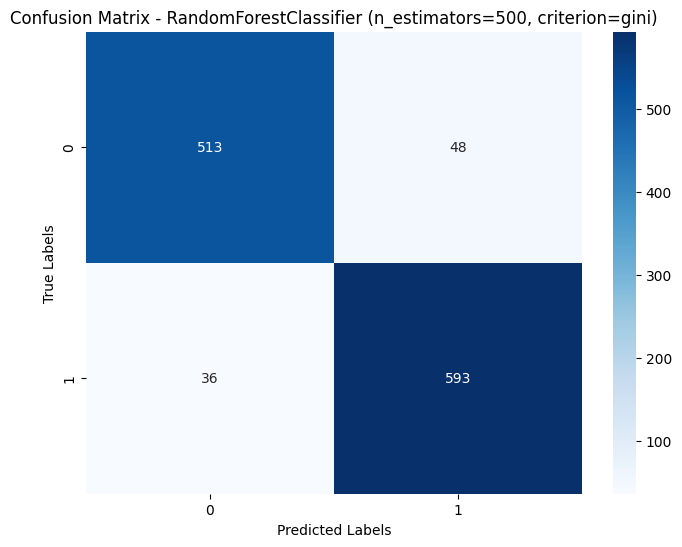

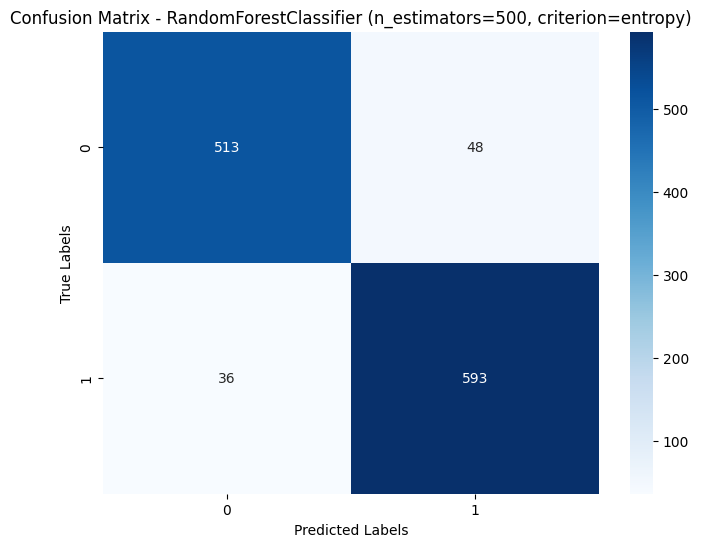

In [19]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
random_results=[]
for n_estimators in [100,200,300,400,500]:
    for criterion in ['gini', 'entropy']:
        randomForestClassifier =  RandomForestClassifier(n_estimators=n_estimators,criterion=criterion)
        scores = cross_val_score(randomForestClassifier, X_scaled, y, cv=5)
        y_pred = cross_val_predict(randomForestClassifier, X_scaled, y, cv=5)
        # Calculate confusion matrix
        cm = confusion_matrix(y, y_pred)
        precision, specifity, sensitivity = calculate_metrics(cm)

        # Store the results
        result = {
            'classifier': randomForestClassifier.__class__.__name__,
            'mean_accuracy': np.mean(scores),
            'std_accuracy': np.std(scores),
            'n_estimators':n_estimators,
            'criterion':criterion,
            'precision':precision,
            'specifity':specifity,
            'sensitivity':sensitivity,
        }
        saveConfusionMatix(cm, result)
        random_results.append(result)

# Sort the results based on mean_accuracy in descending order
random_sorted_results = sorted(random_results, key=lambda x: x['mean_accuracy'], reverse=True)
# save results into CSV for later analysis
pd.DataFrame(random_sorted_results).to_csv('random_results.csv')
# Print the best combination
print("Best Random Combination:")
print( random_sorted_results[0])